In [ ]:
"""
This is a script used to quickly tune Pyflex parameters to see how 
changing parameters affects the chosen windows for a given set of data.
Pyflex parameters can be overwritten, and then data will be run through
the Pyatoa workflow to generate waveform figures with misfit windows
and adjoint sources
"""

In [1]:
import os
import sys
import pyatoa
import pyasdf
import pyflex
import numpy as np
import logging
import warnings

from scipy import signal

# Pyasdf throws HDF5 deprecation warnings, ignore them 
warnings.filterwarnings("ignore") 

In [2]:
def set_pyflex_config(min_period, max_period, stalta_waterlevel=0.07,
                      tshift_acceptance_level=10.,  dlna_acceptance_level=1.3,
                      cc_acceptance_level=0.7,  s2n_limit=1.5,
                      min_surface_wave_velocity=3.,
                      max_time_before_first_arrival=50., c_0=1., c_1=1.5,
                      c_2=0., c_3a=4., c_3b=2.5, c_4a=2., c_4b=5.,
                      check_global_data_quality=False,
                      snr_integrate_base=False, snr_max_base=3.):
    """
    Set the Pyflex configuration based on function arguments, if no arguments are
    given, default Pyflex values are used. Returns the Pyflex Config object
    Some parameters are left permanently set to default values.
    """
    pyflex_config = pyflex.Config(
        min_period=min_period, max_period=max_period,
        stalta_waterlevel=stalta_waterlevel,
        tshift_acceptance_level=tshift_acceptance_level, tshift_reference=0.,
        dlna_acceptance_level=dlna_acceptance_level, dlna_reference=0.,
        cc_acceptance_level=cc_acceptance_level, s2n_limit=s2n_limit,
        earth_model="ak135",
        min_surface_wave_velocity=min_surface_wave_velocity,
        max_time_before_first_arrival=max_time_before_first_arrival,
        c_0=c_0, c_1=c_1, c_2=c_2, c_3a=c_3a, c_3b=c_3b, c_4a=c_4a, c_4b=c_4b,
        check_global_data_quality=check_global_data_quality,
        snr_integrate_base=snr_integrate_base, snr_max_base=snr_max_base,
        noise_start_index=0, signal_start_index=None, signal_end_index=-1,
        window_weight_fct=None,  window_signal_to_noise_type="amplitude",
        resolution_strategy="interval_scheduling"
        )

    return pyflex_config

In [ ]:
def run_pyatoa(config, station=None, save=False, show=False):
    """
    Small script to run Pyatoa given a config object. Ability to run only
    for a single station, or for all stations in the H5 datset
    Pyasdf dataset must exist, named with the event ID
    
    :type config: pyatoa.Config
    :param config: config object from Pyatoa
    :type station: str
    :param station: If not None, specifies the station to process
    :type save: str
    :param save: if not False, specifies the filename to save the figure
    :type show: bool
    :param show: whether or not to show the figure
    """
    # append title to title of figure
    append_title = ("\nstalta_waterlevel={0}; tshift_acceptance_level={1}; "
                    "dlna_acceptance_level={2}; cc_acceptance_level={3}; "
                    "\ns2n_limit={4}; max_time_before_first_arrival={5}; "
                    "c_0={6}; c_1={7}; c_2={8}; c_3a={9}; c_3b={10}; "
                    "\nc_4a={11}; c_4b={12}")
    pfc = config.pyflex_config[1]
    append_title = append_title.format(
            pfc.stalta_waterlevel, pfc.tshift_acceptance_level,
            pfc.dlna_acceptance_level, pfc.cc_acceptance_level,
            pfc.s2n_limit, pfc.max_time_before_first_arrival,
            pfc.c_0, pfc.c_1, pfc.c_2, pfc.c_3a, pfc.c_3b,
            pfc.c_4a, pfc.c_4b
            )


    mgmt = pyatoa.Manager(config=config, empty=True)

    ds_path = os.path.join(os.getcwd(), "{}.h5".format(config.event_id))
    with pyasdf.ASDFDataSet(ds_path) as ds:
        mgmt.event = ds.events[0]
        if station:
            sta_list = [station]
        else:
            sta_list = ds.waveforms.list()
        for sta in sta_list:
            mgmt.st_obs = ds.waveforms[sta].observed
            mgmt.st_syn = ds.waveforms[sta].synthetic_m00
            mgmt.inv = ds.waveforms[sta].StationXML
            mgmt.preprocess()
            mgmt.run_pyflex()
            mgmt.run_pyadjoint()
            
            # Print the max amplitude of adjoint source * synthetic waveform
            if mgmt.adj_srcs:
                for comp in config.component_list:
                    adj_src = mgmt.adj_srcs.get(comp)
                    if adj_src:
                        print("{}: {:.2E}".format(
                            comp, (adj_src.adjoint_source[::-1] * mgmt.st_syn.select(component=comp)[0].data).max())
                             )
            if save:
                save = os.path.join(os.getcwd(), config.event_id, f"{sta}.png")
            mgmt.plot_wav(show=show, save=save, append_title=append_title, dpi=75)
            mgmt.reset(hard_reset=False)      
            


In [ ]:
def initialize(event_id, model_number):
    """
    Initialize logger, config object and make figure directory if
    figures are to be saved
    
    :type event_id: str
    :param event_id: event id used to ID pyasdf file with data
    :type model_number: str
    :param model_number: model to process
    """
    config = pyatoa.Config(
                event_id=event_id,
                model_number=model_number,
                min_period=10,
                max_period=30,
                filter_corners=4,
                rotate_to_rtz=False,
                zero_pad=0,
                unit_output="DISP",
                window_amplitude_ratio=0.,
                pyflex_config="default",
                adj_src_type="mtm_hikurangi_strict",
                synthetics_only=True,
                cfgpaths={'synthetics':[],
                          'waveforms':[],
                          'responses':[]
                          }
                )
    setattr(config.pyadjoint_config[1], "min_cycle_in_window", 100)
    figure_directory = os.path.join(os.getcwd(), event_id)
    if not os.path.exists(figure_directory):
        os.makedirs(figure_directory)

    return config

In [ ]:
# Run initalization once
pyatoa_config = initialize(event_id="2013p142607", model_number="m00")
pyflex_cfg = set_pyflex_config(min_period=pyatoa_config.min_period,
                               max_period=pyatoa_config.max_period
                              )
pyatoa_config.pyflex_config = ("test_config", pyflex_cfg)

[2019-10-23 11:32:57,732] - pyflex - INFO: Calculated travel times.
[2019-10-23 11:32:57,732] - pyflex - INFO: Calculating envelope of synthetics.
[2019-10-23 11:32:57,734] - pyflex - INFO: Calculating STA/LTA.
[2019-10-23 11:32:57,737] - pyflex - INFO: Initial window selection yielded 16 possible windows.
[2019-10-23 11:32:57,738] - pyflex - INFO: Rejection based on travel times retained 15 windows.
[2019-10-23 11:32:57,738] - pyflex - INFO: Rejection based on minimum window length retained 12 windows.
[2019-10-23 11:32:57,740] - pyflex - INFO: Water level rejection retained 12 windows
[2019-10-23 11:32:57,741] - pyflex - INFO: Single phase group rejection retained 8 windows
[2019-10-23 11:32:57,742] - pyflex - INFO: Curtailing left
[2019-10-23 11:32:57,745] - pyflex - INFO: Curtailing left
[2019-10-23 11:32:57,746] - pyflex - INFO: Removing duplicates retains 6 windows.
[2019-10-23 11:32:57,747] - pyflex - INFO: Rejection based on minimum window length retained 6 windows.
[2019-10-23

Z: 3.67E-01


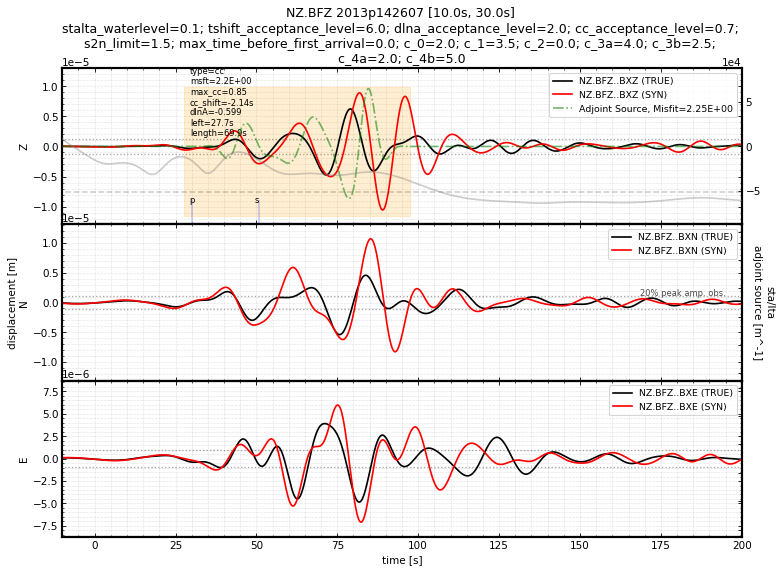

[2019-10-23 11:33:02,058] - pyflex - INFO: Calculated travel times.
[2019-10-23 11:33:02,059] - pyflex - INFO: Calculating envelope of synthetics.
[2019-10-23 11:33:02,061] - pyflex - INFO: Calculating STA/LTA.
[2019-10-23 11:33:02,064] - pyflex - INFO: Initial window selection yielded 2 possible windows.
[2019-10-23 11:33:02,065] - pyflex - INFO: Rejection based on travel times retained 2 windows.
[2019-10-23 11:33:02,065] - pyflex - INFO: Rejection based on minimum window length retained 2 windows.
[2019-10-23 11:33:02,067] - pyflex - INFO: Water level rejection retained 2 windows
[2019-10-23 11:33:02,068] - pyflex - INFO: Single phase group rejection retained 2 windows
[2019-10-23 11:33:02,069] - pyflex - INFO: Removing duplicates retains 2 windows.
[2019-10-23 11:33:02,070] - pyflex - INFO: Rejection based on minimum window length retained 2 windows.
[2019-10-23 11:33:02,072] - pyflex - INFO: SN amplitude ratio window rejection retained 2 windows
[2019-10-23 11:33:02,078] - pyflex 

Z: 9.46E-03
E: 0.00E+00


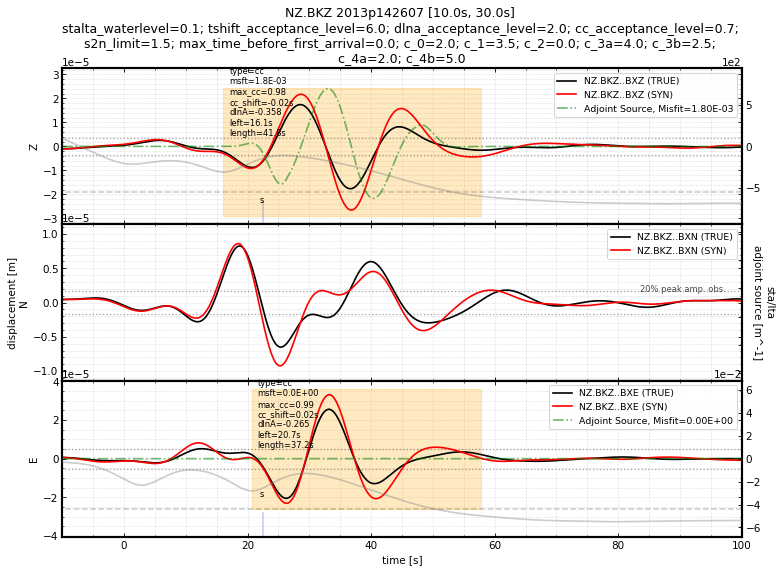

[2019-10-23 11:33:05,255] - pyflex - INFO: Calculated travel times.
[2019-10-23 11:33:05,255] - pyflex - INFO: Calculating envelope of synthetics.
[2019-10-23 11:33:05,257] - pyflex - INFO: Calculating STA/LTA.
[2019-10-23 11:33:05,259] - pyflex - INFO: Initial window selection yielded 7 possible windows.
[2019-10-23 11:33:05,260] - pyflex - INFO: Rejection based on travel times retained 7 windows.
[2019-10-23 11:33:05,263] - pyflex - INFO: Rejection based on minimum window length retained 6 windows.
[2019-10-23 11:33:05,266] - pyflex - INFO: Water level rejection retained 1 windows
[2019-10-23 11:33:05,268] - pyflex - INFO: Single phase group rejection retained 1 windows
[2019-10-23 11:33:05,269] - pyflex - INFO: Removing duplicates retains 1 windows.
[2019-10-23 11:33:05,269] - pyflex - INFO: Rejection based on minimum window length retained 1 windows.
[2019-10-23 11:33:05,271] - pyflex - INFO: SN amplitude ratio window rejection retained 1 windows
[2019-10-23 11:33:05,276] - pyflex 

Z: 3.61E-02
N: 4.81E-02
E: 5.89E-02


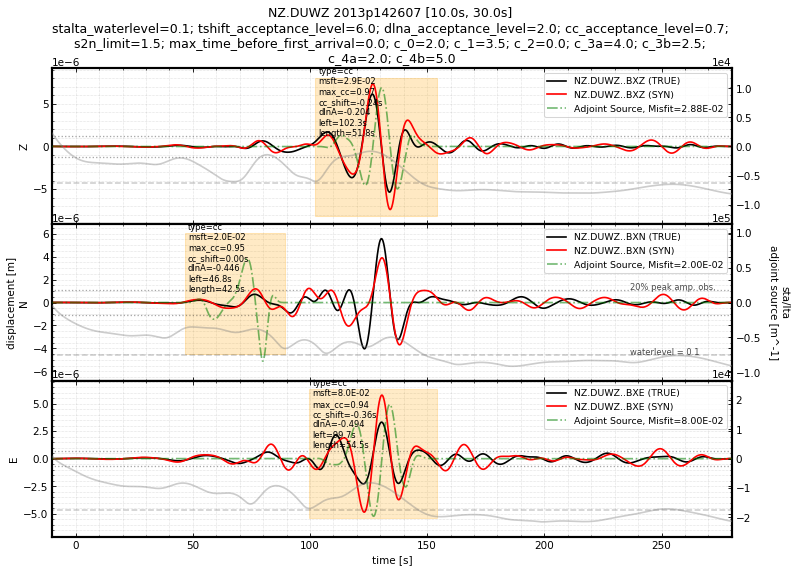

[2019-10-23 11:33:09,812] - pyflex - INFO: Calculated travel times.
[2019-10-23 11:33:09,813] - pyflex - INFO: Calculating envelope of synthetics.
[2019-10-23 11:33:09,816] - pyflex - INFO: Calculating STA/LTA.
[2019-10-23 11:33:09,821] - pyflex - INFO: Initial window selection yielded 2 possible windows.
[2019-10-23 11:33:09,822] - pyflex - INFO: Rejection based on travel times retained 2 windows.
[2019-10-23 11:33:09,823] - pyflex - INFO: Rejection based on minimum window length retained 2 windows.
[2019-10-23 11:33:09,826] - pyflex - INFO: Water level rejection retained 1 windows
[2019-10-23 11:33:09,827] - pyflex - INFO: Single phase group rejection retained 1 windows
[2019-10-23 11:33:09,828] - pyflex - INFO: Removing duplicates retains 1 windows.
[2019-10-23 11:33:09,831] - pyflex - INFO: Rejection based on minimum window length retained 1 windows.
[2019-10-23 11:33:09,834] - pyflex - INFO: SN amplitude ratio window rejection retained 1 windows
[2019-10-23 11:33:09,838] - pyflex 

Z: 1.46E-01
E: 1.82E-01


KeyboardInterrupt: 

In [32]:
# Set attributes and run Pyatoa, this is the tuning cell
# 1) Main tuning parameters in order
setattr(pyflex_cfg, 's2n_limit', 1.5)  # 1.5
setattr(pyflex_cfg, 'tshift_acceptance_level', 6.)  # 10.
setattr(pyflex_cfg, 'cc_acceptance_level', 0.7)  # 0.7
setattr(pyflex_cfg, 'dlna_acceptance_level', 2.)  # 1.3
setattr(pyflex_cfg, 'stalta_waterlevel', 0.1)  # 0.07

# 2) Fine tuning parameters, only applied to STA/LTA waveform E(t)
# c_0: internal minima height - reject if E(t)_peak < stalta_wavterlevel * c_0
setattr(pyflex_cfg, 'c_0', 2.)  # 1. 
# c_1: window length - minimumum window length = c_1 * min_period
setattr(pyflex_cfg, 'c_1', 3.5)  # 1.5 
# c_2: maxima prominence - central peak vs surrounding minima, hard to control
setattr(pyflex_cfg, 'c_2', 0.)  # 0.
# c_3: separation height
setattr(pyflex_cfg, 'c_3a', 4.)  # 4.
setattr(pyflex_cfg, 'c_3b', 2.5)  # 2.5
# c_4: emergent E(t) signal
setattr(pyflex_cfg, 'c_4a', 2.)  # 2.
setattr(pyflex_cfg, 'c_4b', 5.)  # 5.

# 3) Misc. tuning parameters
setattr(pyflex_cfg, 'max_time_before_first_arrival', 0.)  # 50.
setattr(pyflex_cfg, 'min_surface_wave_velocity', 2.75)  # 3.

# 4) For observation waveforms only
setattr(pyflex_cfg, 'check_global_data_quality', False)  # False
setattr(pyflex_cfg, 'snr_integrate_base', False)  # False
setattr(pyflex_cfg, 'snr_max_base', 3.)  # 3.

logger = logging.getLogger("pyflex")
logger.setLevel(logging.DEBUG)

# Run pyatoa with the overwritten configuration
pyatoa_config.pyflex_config = ("test_config", pyflex_cfg)
mgmt = run_pyatoa(pyatoa_config, station=None, save=False, show=True)

In [30]:
print((mgmt.adj_srcs["E"].adjoint_source[::-1] * mgmt.st_syn.select(component="E")[0].data).max())
print((mgmt.adj_srcs["Z"].adjoint_source[::-1] * mgmt.st_syn.select(component="Z")[0].data).max())
print((mgmt.adj_srcs["N"].adjoint_source[::-1] * mgmt.st_syn.select(component="N")[0].data).max())

TypeError: 'NoneType' object is not subscriptable